# Yolo v1 using minai
> Supercharge yolo v1 with miniai power

In [31]:
import torch
import torchvision.transforms as transforms
import fastcore.all as fc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import partial

from minai import *
from pilus_project.yolov1 import *

In [2]:
set_seed(42)

In [24]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])
IMG_DIR = "../data/images"
LABEL_DIR = "../data/labels"

bs = 8

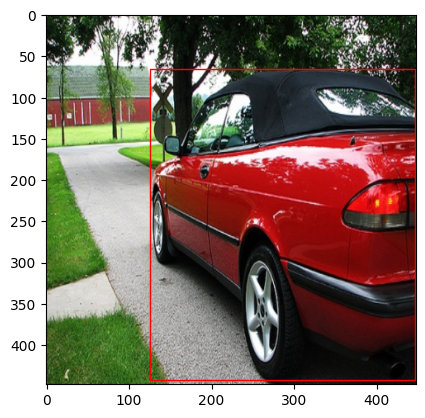

In [16]:
trn_ds = VOCDataset("../8examples.csv", 
                    transform=transform,
                    img_dir=IMG_DIR,
                    label_dir=LABEL_DIR)
x0, y0 = trn_ds[0]
plot_image(x0, cellboxes_to_boxes(y0.unsqueeze(0))[0])

In [64]:
examples_val_8 = pd.read_csv("../test.csv").iloc[:8]
examples_val_8

,000001.jpg,000001.txt
0,000002.jpg,000002.txt
1,000003.jpg,000003.txt
2,000004.jpg,000004.txt
3,000006.jpg,000006.txt
4,000008.jpg,000008.txt
5,000010.jpg,000010.txt
6,000011.jpg,000011.txt
7,000013.jpg,000013.txt


In [65]:
examples_val_8.to_csv('../8examples_val.csv', index=False)

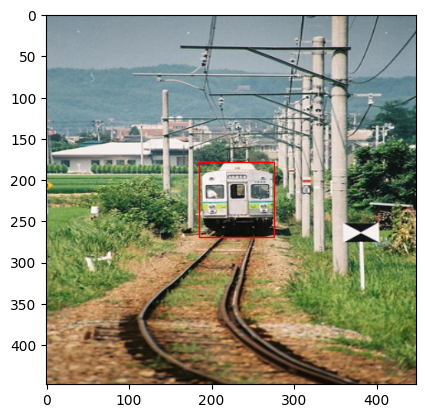

In [66]:
val_ds = VOCDataset(
    "../8examples_val.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)
x0, y0 = val_ds[0]
plot_image(x0, cellboxes_to_boxes(y0.unsqueeze(0))[0])

In [67]:
len(val_ds)

8

In [68]:
trn_dl, val_dl = get_dls(trn_ds, val_ds, bs)
xb, yb = next(iter(trn_dl))
xb.shape, yb.shape

(torch.Size([8, 3, 448, 448]), torch.Size([8, 7, 7, 30]))

In [69]:
dls = DataLoaders(trn_dl, val_dl)

## Learner 

In [75]:
cbs = [
    TrainCB(),
    DeviceCB(),
    MetricsCB(),
]
opt = partial(torch.optim.AdamW, betas=(0.9,0.95), eps=1e-5)

In [76]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20)

loss,epoch,train,time
645.321,0,train,00:04
451.112,0,eval,00:01
240.035,1,train,00:03
446.705,1,eval,00:01
154.819,2,train,00:04
442.292,2,eval,00:01
111.510,3,train,00:01
413.846,3,eval,00:01
85.826,4,train,00:04
409.855,4,eval,00:01


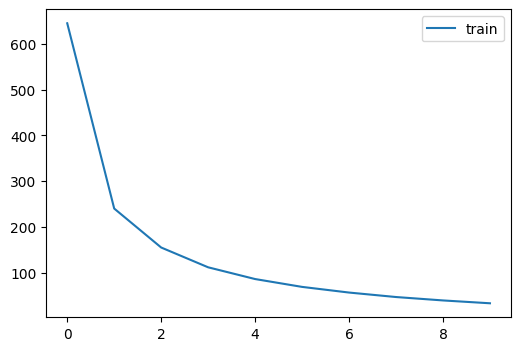

In [77]:
learn = Learner(model, dls, YoloLoss(), lr=2e-5, cbs=cbs, opt_func=opt)
learn.fit(10, cbs=[ProgressCB(plot=True)])